# Práctico 3 - Introducción al Aprendizaje Automático

## Modelos de Precios de Mercado
Queremos crear un modelo que prediga si el precio de una acción va a subir o bajar de acuerdo a información del pasado. Para ello implementaremos algunos modelos derivados de la teoria económica respecto de como valuar una activo con flujo de fondos inciertos.


### Capital Asset Pricing Model (CAPM)

El modelo de CAPM propuesto por William Sharpe a partir del desarrollo de Markowitz sobre carteras eficientes, busca predecir el retorno de un activo en función del comportamiento global del mercado, y de la relación del activo puntual con el mercado. 

Según este modelo, que se puede expresar de la siguiente manera: 

$$
E(r_i) = r_f + \beta  [ E(r_m) - r_f ] 
$$

El retorno esperado del activo i, es igual al retorno libre de riesgo (o tasa libre de riesgo), más el exceso de retorno esperado de mercado (es decir lo que se espera que rinda el mercado por sobre la tasa libre de riesgo) escalado por un coeficiente beta. Este coeficiente beta es el conciente entre la covarianza del activo con el mercado sobre la varianza del mercado, y se interpreta como un multiplicador de riesgo de mercado.

Pueden ver una explicación completa en: https://economipedia.com/definiciones/modelo-valoracion-activos-financieros-capm.html

Adicionalmente, se puede agregar un término independiente como ordenada al origen alfa, que represanta una ganancia extraordinaria no explicada por la relacion con de la acción con el mercado sino por factores extraordinarios o arbitrages en caso de estrategias. De allí el famoso "buscar alfa" siendo una directriz de todos los portafolios managers. 

$$
E(r_i) = \alpha + r_f + \beta  [ E(r_m) - r_f ]
$$

Para realizar este ejercicio, deberán descargar el precio de una acción y del mercado asociado (por ejemplo GOOG y NASDAQ). En ambos casos tomar los retornos y tomar una tasa libre de riesgo. A continuación, deberán probar varias regresiones para comprobar el beta, y examinar si el agregado de una ordenada al origen aporta a los resultados. La idea es que seleccionen varias acciones para modelarlo con diferentes activos. 

Una vez que lo hayan hecho, adionalmente responder las siguientes preguntas:

1. ¿Es fácil encontrar $\alpha$ distinto de cero?

2. ¿Qué interpretación le podemos dar a $\beta$?

3. ¿En qué momento nos gustaría buscar activos con $\beta$ > 1 y $\beta$ < 1? ¿Qué implica tener un $\beta$ < 0?



### 0) Importación de librerías

In [23]:
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import yfinance as yf # Agrego esto # pip install yfinance --upgrade --no-cache-dir
import numpy as np # Agrego esto
import seaborn as sns
from datetime import timedelta

### 1) Download dataframe

In [24]:
yf.pdr_override()

start_date = "2000-01-01"
end_date = "2020-12-31"

df_activo = pdr.get_data_yahoo("GOOG", start=start_date, end=end_date)
df_mercado = pdr.get_data_yahoo("NDAQ", start=start_date, end=end_date)
df_mercado.head()
# df_1['Adj Close'].plot(figsize=(16,9))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-07-01,15.0,15.0,15.0,15.00,12.815305,1300
2002-07-02,15.5,16.5,15.0,15.13,12.926373,7000
2002-07-03,14.0,16.0,14.0,15.00,12.815305,10200
2002-07-05,15.0,15.0,15.0,15.00,12.815305,500
2002-07-08,14.0,14.0,14.0,14.00,11.960951,300


### 2) Determinación de retornos totales

In [25]:
df_activo['Retornos'] = df_activo['Adj Close'].pct_change()*100
df_mercado['Retornos'] = df_mercado['Adj Close'].pct_change()*100
df_mercado.head()

,Open,High,Low,Close,Adj Close,Volume,Retornos
Date,,,,,,,
2002-07-01,15.0,15.0,15.0,15.00,12.815305,1300,NaN
2002-07-02,15.5,16.5,15.0,15.13,12.926373,7000,0.866681
2002-07-03,14.0,16.0,14.0,15.00,12.815305,10200,-0.859234
2002-07-05,15.0,15.0,15.0,15.00,12.815305,500,0.000000
2002-07-08,14.0,14.0,14.0,14.00,11.960951,300,-6.666669


In [26]:
# Graficación
retornos_concat = pd.concat([df_activo['Retornos'], df_mercado['Retornos']], axis=1, keys=['retornos_activo', 'retornos_mercado'])
retornos_concat.dropna(inplace=True) # descarto fechas en que tengo NaN en algún retorno
retornos_concat.head()

# ver de hacer dropna antes de hacer pct_change

,retornos_activo,retornos_mercado
Date,,
2004-08-20,7.942987,2.500062
2004-08-23,1.006371,-0.813049
2004-08-24,-4.140761,0.000000
2004-08-25,1.077523,0.000000
2004-08-26,1.801882,-0.819659


El dataset `retorno_concat` sería el dataset de `train + validation + test`

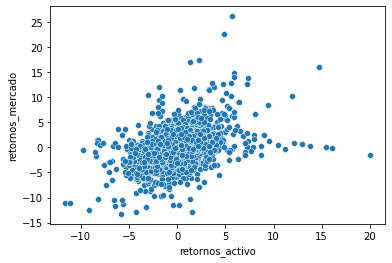

In [27]:
ax = sns.scatterplot(data=retornos_concat, x='retornos_activo', y='retornos_mercado')

### 3.1 ) Determinación de beta: Método mínimos cuadrados [Fórmula cerrada Modelo Lineal]

### Regresión lineal

In [28]:
# VER HOJA ESCRITA A MANO
# Adopto una tasa libre de riesgo (1%) PREGUNTA: Cómo se elige este valor?
# En EEUU se usa la tasa de los bonos que es más cercana a la taasa riskfree. En principio r_f puede ser = 0
r_f = 0.01

train_test = retornos_concat
x_i = np.array(train_test['retornos_mercado'].values - r_f)
y_i = np.array(train_test['retornos_activo'].values - r_f)

beta = sum(y_i * x_i)/ sum(x_i**2)
y_i_pred = beta*x_i

correlation = np.corrcoef(y_i, y_i_pred)[0,1]

print('beta =', beta)
print('correlation =', correlation)

beta = 0.32626681787945144
correlation = 0.41529044147425637


### Graficación

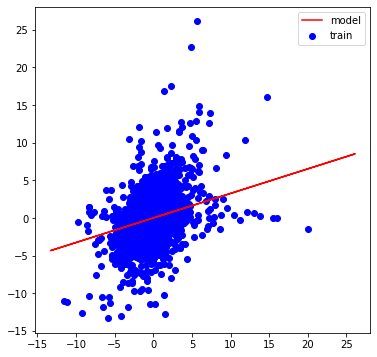

In [29]:
plt.figure(figsize=(6, 6))
plt.scatter(data=retornos_concat, x='retornos_activo', y='retornos_mercado', color="blue", label='train')
plt.plot(x_i, y_i_pred, color='red', label='model')
plt.legend()

### 3.2 ) Determinación de beta: Método mínimos cuadrados [Entrenamiento]

### Separación de datasets: train, validation, test

In [30]:
data_train = train_test
data_train.reset_index(level='Date', inplace=True)
data_train.set_index('Date')

# data_train['Date'] = pd.to_datetime(data_train['Date'])
data_train.head()

# Puedo usar sólo train. A lo sumo usar train y test. Se suele hacer cross validation

,Date,retornos_activo,retornos_mercado
0,2004-08-20,7.942987,2.500062
1,2004-08-23,1.006371,-0.813049
2,2004-08-24,-4.140761,0.000000
3,2004-08-25,1.077523,0.000000
4,2004-08-26,1.801882,-0.819659


In [31]:
data_train.Date.min(), data_train.Date.max()

(Timestamp('2004-08-20 00:00:00'), Timestamp('2020-12-30 00:00:00'))

In [32]:
# Seperación temporal (últimos ~30 días para test y penúltimos ~30 días para validación)
split_test_date = (pd.to_datetime(data_train.Date).max()-timedelta(days=44)).date()
split_val_date = (pd.to_datetime(data_train.Date).max()-timedelta(days=88)).date()
print(split_test_date, split_val_date)

# CORREGIR CÓMO TOMA LOS DÍAS PORQUE SON DÍAS HÁBILES NO CORRIDOS!!!
# sklearn función split para series temporales

2020-11-16 2020-10-03


In [33]:
# Separación de los últimos 30 días para test
data_test = data_train.loc[(data_train.Date > str(split_test_date))]

# Separación de los penúltimos 30 días para validación
data_val = data_train.loc[(data_train.Date > str(split_val_date)) & (data_train.Date <= str(split_test_date))]

# Uso el resto como entrenamiento
data_train = data_train.loc[(data_train.Date <= str(split_val_date))]

print('Tamaños data_test:', data_test.shape[0], ', data_val:' , data_val.shape[0], ', data_train:', data_train.shape[0])

Tamaños data_test: 30 , data_val: 31 , data_train: 4059


In [34]:
# data_test.set_index('Date', inplace=True)
# data_val.set_index('Date', inplace=True)
# data_train.set_index('Date', inplace=True)

In [35]:
data_test.head()

,Date,retornos_activo,retornos_mercado
4090,2020-11-17,-0.630409,-0.955942
4091,2020-11-18,-1.320227,-1.286899
4092,2020-11-19,0.981235,1.654042
4093,2020-11-20,-1.231921,1.258414
4094,2020-11-23,-0.420732,-0.253308


### Regresión lineal

In [36]:
# Adopto una tasa libre de riesgo (1%) PREGUNTA: Cómo se elige este valor?
r_f = 0.01

X_train = np.array(data_train['retornos_mercado'].values - r_f)
y_train = np.array(data_train['retornos_activo'].values - r_f)

X_val = np.array(data_val['retornos_mercado'].values - r_f)
y_val = np.array(data_val['retornos_activo'].values - r_f)

X_test = np.array(data_val['retornos_mercado'].values - r_f)
y_test = np.array(data_val['retornos_activo'].values - r_f)

In [37]:
X_train.shape

(4059,)

In [38]:
def linear_least_squares(X, y, add_bias=True):
    
    if add_bias:
        X_b = np.stack((X, np.ones(X.shape[0])), axis=1)  # add bias
    else:
        X_b = np.stack((X, np.zeros(X.shape[0])), axis=1) # anulo bias
        
    return np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T.dot(y))

# ---------------------------------------------------------------- #

def f(X, w, add_bias=True):
    
    if add_bias:
        X_b = np.stack((X, np.ones(X.shape[0])), axis=1)  # add bias: (1, x)
    else:
        X_b = np.stack((X, np.zeros(X.shape[0])), axis=1) # anulo bias
        
    return X_b.dot(w)

### Entrenamiento

In [39]:
w = linear_least_squares(X_train, y_train, add_bias=False)

In [40]:
w

array([0.32515089, 0.        ])

Para el modelo CAPM serían `alpha` y `beta`

### Graficación

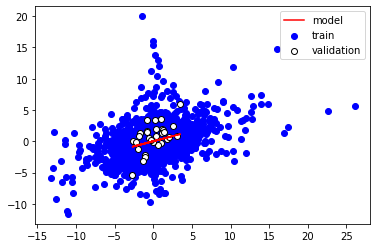

In [41]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_val, y_val, color="white", edgecolor="k", label="validation")
plt.plot(X_val, f(X_val, w), color="red", label="model")
plt.legend()
plt.show()

### Evaluación en entrenamiento: Error Cuadrático Medio

Se obtienen los valores predichos para los datos de entrenamiento y de validación. Calcularemos el error cuadrático medio sobre ambos conjuntos de datos. Luego haremos la predicción sobre el conjunto de testeo y calcularemos también el erro cuadrático medio.



In [42]:
y_train_pred = f(X_train, w, add_bias=False)
y_val_pred = f(X_val, w, add_bias=False)

In [43]:
from sklearn.metrics import mean_squared_error

train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_val_pred)
print(f'Train error: {train_error:f}')
print(f'Val error: {val_error:f}')

Train error: 3.079956
Val error: 3.938921


### Predicción y evaluación: Error Cuadrático Medio

In [44]:
y_train_pred = f(X_train, w, add_bias=False)
y_test_pred = f(X_test, w, add_bias=False)

In [45]:
from sklearn.metrics import mean_squared_error

train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)
print(f'Train error: {train_error:f}')
print(f'Val error: {test_error:f}')

Train error: 3.079956
Val error: 3.938921


In [46]:
# CONSULTAR POR QUE DAN IGUAL??? ESTÁ BIEN PLANTEADO CONCEPTUALMENTE EL CALCULO DE ERROR DE VALIDACION Y TEST???

### 4.1 ) Determinación de alpha y beta: Método mínimos cuadrados [Fórmula cerrada Modelo Lineal]

### Regresión lineal

In [47]:
# VER HOJA ESCRITA A MANO
# Adopto una tasa libre de riesgo (1%) PREGUNTA: Cómo se elige este valor?
r_f = 0.01

train_test = retornos_concat
x_i = np.array(train_test['retornos_mercado'].values - r_f)
y_i = np.array(train_test['retornos_activo'].values - r_f)
n = len(x_i)

beta = (sum(y_i * x_i) - n * np.mean(y_i) * np.mean(x_i))/ (sum(x_i**2) - n * (np.mean(x_i)**2))
alpha = np.mean(y_i) - beta * np.mean(x_i)

y_i_pred = alpha + beta * x_i

correlation = np.corrcoef(y_i, y_i_pred)[0,1]

print('alpha =', alpha)
print('beta =', beta)
print('correlation =', correlation)

alpha = 0.06260660132086379
beta = 0.32525065532946357
correlation = 0.41529044147425637


### Graficación

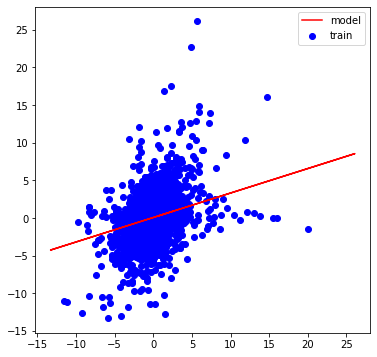

In [48]:
plt.figure(figsize=(6, 6))
plt.scatter(data=retornos_concat, x='retornos_activo', y='retornos_mercado', color="blue", label='train')
plt.plot(x_i, y_i_pred, color='red', label='model')
plt.legend()

### 4.2 ) Determinación de alpha y beta: Método mínimos cuadrados [Entrenamiento]

REPETIR LO MISMO QUE PASOS 3.1) PERO LLAMANDO LAS FUNCIONES DE LA SIGUIENTE MANERA (con add_bias=True para
que el modelo considere el término de ordenada al origen):

linear_least_squares(X, y, add_bias=True)

f(X, w, add_bias=True)

### Modelos Autorregresivos para predecir precios.

Para esta parte del práctico, nos gustaría utilizar precios del pasado para poder estimar cuál va a ser el precio de una acción más adelante. Las regresiones que vemos en la introducción al aprendizaje automático no son las mismas que deben usarse cuando estamos trabajando con precios de mercado, ya que estos datos son series de tiempo. Para trabajar con este tipo de datos, es necesario generar **modelos autorregresivos**.

Si suponemos que $y_t$ es el precio de nuestra acción en el tiempo $t$, podemos generar el siguiente modelo autorregresivo:

$$
y_t = \delta + \phi_1 y_{t-1} + \dots + \phi_p y_{t-p} + \epsilon_t
$$

Existen otras variables que podemos agregar (como estacionariedad o tendencias), pero para este práctico podemos usar solamente el modelo `AutoReg` de la librería StatsModels: https://www.statsmodels.org/stable/examples/notebooks/generated/autoregressions.html.

El **ejercicio** para esta sección es crear una función que reciba 4 parámetros:
- El *ticker* de un activo.
- Una *fecha* a partir de la cual se van a querer predecir los precios del activo.
- Un *número de días* hacia atrás que se van a usar para ajustar el modelo autorregresivo.
- Un *número de días* hacia adelante para los cuales van a querer predecir el precio del activo utilizando el modelo entrenado.

Esta función se debe encargar de buscar los precios del ticker, realizar el ajuste y predecir el precio de la acción hacia delante. Además, debe devolver el [error cuadrático medio](https://es.wikipedia.org/wiki/Error_cuadr%C3%A1tico_medio) de la predicción, comparado con los verdaderos precios del activo.

¿Qué pasa si tratamos de predecir el precio del SPY el día antes del primer cisne negro de 2020 con un modelo que use 15 días hacia atrás?

### 0) Importación de datos

In [49]:
yf.pdr_override()

start_date = "2000-01-01"
end_date = "2020-12-31"

df = pdr.get_data_yahoo("SPY", start=start_date, end=end_date)

df.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.43750,97.506668,8164300
2000-01-04,143.53125,144.06250,139.640625,139.75000,93.693573,8089800
2000-01-05,139.93750,141.53125,137.250000,140.00000,93.861176,12177900
2000-01-06,139.62500,141.50000,137.750000,137.75000,92.352676,6227200
2000-01-07,140.31250,145.75000,140.062500,145.75000,97.716209,8066500
2000-01-10,146.25000,146.90625,145.031250,146.25000,98.051422,5741700
2000-01-11,145.81250,146.09375,143.500000,144.50000,96.878143,7503700
2000-01-12,144.59375,144.59375,142.875000,143.06250,95.914406,6907700
2000-01-13,144.46875,145.75000,143.281250,145.00000,97.213379,5158300


### 1) Preparación de datos

Como lo que se quiere es predecir el precio `Adj Close` en base a valores del pasado, se trabaja sobre los precios del activo y no sobre el espacio de retornos (pct_change).

In [50]:
prices = df[['Adj Close']]
# prices = prices.asfreq(freq ='D', fill_value = .0) # Ver si esto es necesario o no. Rellena valores faltantes (fines de semana) con 0.

prices.reset_index(level='Date', inplace=True)
prices.set_index('Date')

prices.head(10)

,Date,Adj Close
0,2000-01-03,97.506668
1,2000-01-04,93.693573
2,2000-01-05,93.861176
3,2000-01-06,92.352676
4,2000-01-07,97.716209
5,2000-01-10,98.051422
6,2000-01-11,96.878143
7,2000-01-12,95.914406
8,2000-01-13,97.213379
9,2000-01-14,98.533318


### 2) Chequeo rápido de autocorrelación

Hay una verificación visual rápida que podemos hacer para ver si hay una autocorrelación en nuestro conjunto de datos de series de tiempo.

Podemos graficar la observación en el paso de tiempo anterior (t-1) con la observación en el siguiente paso de tiempo (t + 1) como un diagrama de dispersión.

Esto se puede hacer manualmente creando primero una versión de retraso (shift) del conjunto de datos de series de tiempo y usando una función de diagrama de dispersión incorporada en la biblioteca de Pandas.

Pero hay una manera más fácil. Pandas proporciona una gráfica incorporada para hacer exactamente esto, llamada función lag_plot ().

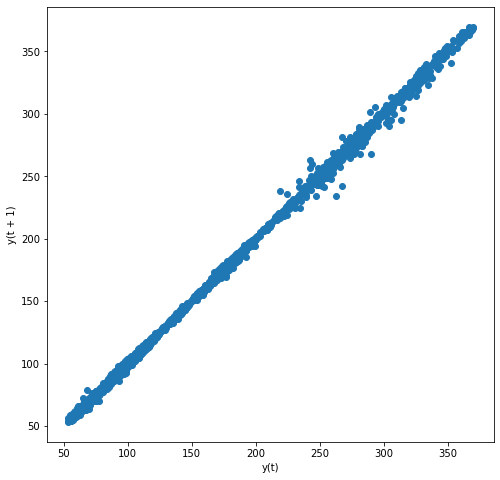

In [51]:
from pandas.plotting import lag_plot

plt.figure(figsize=(8, 8))
lag_plot(prices['Adj Close'])
plt.show()

A simple vista puede observarse una correlación entre los datos. Numéricamente, esto puede cuantificarse mediante el coeficiente Pearson, que se determina a contninuación.

In [52]:
corr_data = pd.concat([prices['Adj Close'].shift(1), prices['Adj Close']], axis=1)
corr_data.columns = ['t-1', 't+1']
result = corr_data.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.999691
t+1  0.999691  1.000000


Se observa una alta correlación positiva (0.999)

### 3) Modelo

### Separación de conjuntos train y test

In [53]:
print('Fecha máxima y mínima:')
prices.Date.min(), prices.Date.max()

Fecha máxima y mínima:


(Timestamp('2000-01-03 00:00:00'), Timestamp('2020-12-30 00:00:00'))

In [54]:
print('Cantidad de días:' , prices.shape[0])

Cantidad de días: 5283


In [55]:
# train: n días antes del conjunto train separado en una fecha fijada
# test: n días posteriores del conjunto test separado en la misma fecha fijada

date_split = "2020-01-01" # ingresar fecha de separación
n_back = 15 # días atrás para definir fecha de inicio de data_train (no es la cantidad de datos)
n_forward = 7 # días adelante para definir fecha de fin data_test (no es la cantidad de datos)

data_train = prices.loc[(prices.Date <= str(date_split))]
data_test = prices.loc[(prices.Date > str(date_split))]

limit_train_date = (pd.to_datetime(data_train.Date).max()-timedelta(days=n_back)).date()
limit_test_date = (pd.to_datetime(data_test.Date).min()+timedelta(days=n_forward)).date()
print(limit_train_date, limit_test_date)

# Redefino data_train y data_test
data_train = data_train.loc[(data_train.Date > str(limit_train_date)) & (data_train.Date <= str(date_split))]
data_test = data_test.loc[(data_test.Date > str(date_split)) & (data_test.Date <= str(limit_test_date))]

print('Tamaños data_test:', data_train.shape[0], ', data_val:' , data_test.shape[0])
data_train.head()

2019-12-16 2020-01-09
Tamaños data_test: 10 , data_val: 6


,Date,Adj Close
5021,2019-12-17,310.142944
5022,2019-12-18,310.162323
5023,2019-12-19,311.433685
5024,2019-12-20,312.799042
5025,2019-12-23,313.276947


Se observa que asignar un número muy grande a `n_back` genera overfitting en el modelo y la predicción tiene mucho error. El orden de `n_back` debe ser similar al valor de `n_forward`.

### Entrenamiento

In [56]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoReg.html

from statsmodels.tsa.ar_model import AutoReg

values_train = data_train['Adj Close'].values
values_test = data_test['Adj Close'].values

n_lags = 3 # CONSULTAR QUÉ ES ESTE PARÁMETRO

model = AutoReg(values_train, lags=n_lags, old_names=False)
model_fit = model.fit()
# print(model_fit.summary())

In [57]:
print('Coefficients: %s' % model_fit.params)

Coefficients: [175.09732099   0.45656126  -0.72659607   0.71397226]


### Predicción

In [58]:
from sklearn.metrics import mean_squared_error
from math import sqrt

predictions = model_fit.predict(start=len(values_train), end=len(values_train)+len(values_test)-1, dynamic=False)

for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], values_test[i]))

rmse = sqrt(mean_squared_error(values_test, predictions))

print('Test RMSE: %.3f' % rmse)

predicted=315.698791, expected=316.836670
predicted=314.727450, expected=314.437500
predicted=313.520834, expected=315.637115
predicted=314.959241, expected=314.749573
predicted=315.799174, expected=316.427063
predicted=314.276024, expected=318.572632
Test RMSE: 2.031


### 4) Graficación

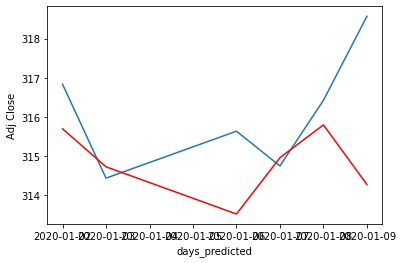

In [59]:
plt.plot(data_test.Date, values_test)
plt.plot(data_test.Date, predictions, color='red')
plt.xlabel("days_predicted")
plt.ylabel("Adj Close")
plt.show()

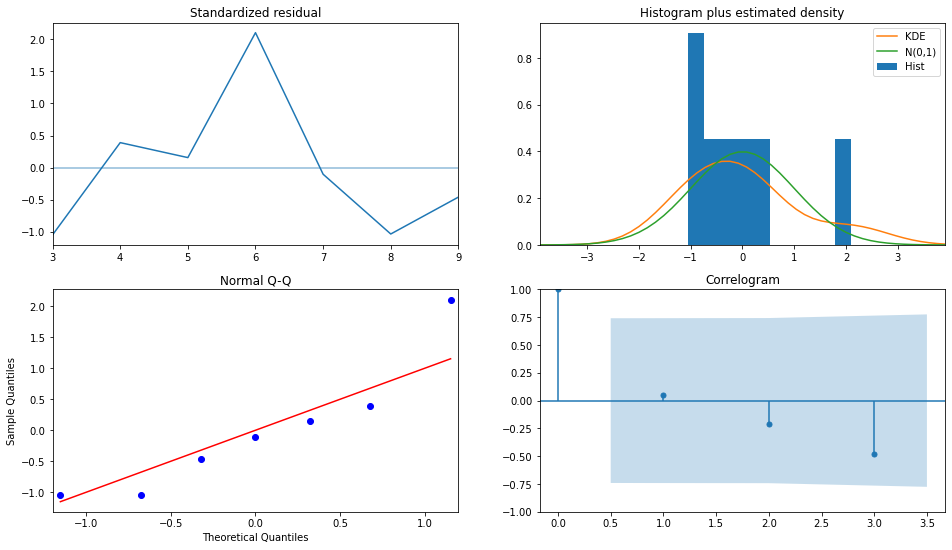

In [60]:
# Diagnóstico

fig = plt.figure(figsize=(16,9))
fig = model_fit.plot_diagnostics(fig=fig, lags=n_lags)

### 5) PENDIENTE: ARMAR FUNCIÓN QUE HAGA TODO ESTE PROCESO

### Árboles de Decisión para predecir suba o baja.

Venimos trabajando los precios con valores continuos, pero otra forma de verlos podría ser convirtiendolos en, por ejemplo, -1 y 1 para saber si el precio está en suba o en baja. De esta forma obtenemos un problema de clasificación que nos permite mirar los datos desde otra perspectiva.

- Etiqueten los datos con 1 si [pct_change](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html) es mayor a cero y 0, -1 si no.
- Entrenen un árbol de decisión que prediga si el valor de un activo va a subir o bajar.
- Reporten las siguientes métricas sobre el modelo resultante.

    - Accuracy
    - Precision
    - Recall
    - F1
    - matriz de confusión

In [61]:
# Desafío: cómo etiquetar el dataset. Hecho en base a pct_change
# usar shift para asignar etiqueta. pct_change de hoy asignar a día siguiente .shift(-1)
# agregar columnas con precios_adj shifteados (hoy, ayer, anteayer) o usar varias columnas no solo adj_close. 
# tener en cuenta el balance del dataset (que haya similar cantidad de 1 y -1)

El etiquetado de datos no suele ser trivial dado a que depende de la naturaleza de los datos. Posiblemente, el precio de un activo suba un poco pero luego continue su declive ¿Cuánto tiene que subir/bajar un precio para ser considerado "suba"/"baja"?. ¿Tiene sentido tomar "periodos de suba/baja" más grandes para predecir si el comportamiento del activo en el futuro?. ¿Se podría utilizar un enfoque más estadístico para elegir el etiquetado?.

Aplicar GridSearch sobre los parámetros y luego para la mejor configuración encontrada, evaluar sobre el conjunto de entrenamiento y sobre el conjunto de evaluación, reportando:

- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

### 0) Importación de datos

In [62]:
yf.pdr_override()

start_date = "2000-01-01"
end_date = "2020-12-31"

df = pdr.get_data_yahoo("SPY", start=start_date, end=end_date)

df.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.43750,97.506668,8164300
2000-01-04,143.53125,144.06250,139.640625,139.75000,93.693573,8089800
2000-01-05,139.93750,141.53125,137.250000,140.00000,93.861176,12177900
2000-01-06,139.62500,141.50000,137.750000,137.75000,92.352676,6227200
2000-01-07,140.31250,145.75000,140.062500,145.75000,97.716209,8066500
2000-01-10,146.25000,146.90625,145.031250,146.25000,98.051422,5741700
2000-01-11,145.81250,146.09375,143.500000,144.50000,96.878143,7503700
2000-01-12,144.59375,144.59375,142.875000,143.06250,95.914406,6907700
2000-01-13,144.46875,145.75000,143.281250,145.00000,97.213379,5158300


### 1) Preparación de datos

In [63]:
# Retornos unitarios en 'Adj Close'
df['Retornos'] = df['Adj Close'].pct_change()
df.head(3)

,Open,High,Low,Close,Adj Close,Volume,Retornos
Date,,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.4375,97.506668,8164300,NaN
2000-01-04,143.53125,144.06250,139.640625,139.7500,93.693573,8089800,-0.039106
2000-01-05,139.93750,141.53125,137.250000,140.0000,93.861176,12177900,0.001789


In [64]:
# Agrego Retorno shifteado para evaluar subida o bajada en precio, etiquetando con 1 o -1
df['Retornos_shift'] = df['Retornos'].shift(-1)
df.head(3)

,Open,High,Low,Close,Adj Close,Volume,Retornos,Retornos_shift
Date,,,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.4375,97.506668,8164300,NaN,-0.039106
2000-01-04,143.53125,144.06250,139.640625,139.7500,93.693573,8089800,-0.039106,0.001789
2000-01-05,139.93750,141.53125,137.250000,140.0000,93.861176,12177900,0.001789,-0.016072


In [65]:
# Etiquetado
df['Etiqueta'] = -1 # inicializo todo con -1
df.loc[df.Retornos_shift > 0, 'Etiqueta'] = 1 # reemplazo valor donde cumple condición de retorno > 0
df.head()

,Open,High,Low,Close,Adj Close,Volume,Retornos,Retornos_shift,Etiqueta
Date,,,,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.4375,97.506668,8164300,NaN,-0.039106,-1
2000-01-04,143.53125,144.06250,139.640625,139.7500,93.693573,8089800,-0.039106,0.001789,1
2000-01-05,139.93750,141.53125,137.250000,140.0000,93.861176,12177900,0.001789,-0.016072,-1
2000-01-06,139.62500,141.50000,137.750000,137.7500,92.352676,6227200,-0.016072,0.058077,1
2000-01-07,140.31250,145.75000,140.062500,145.7500,97.716209,8066500,0.058077,0.003430,1


In [66]:
data = df

data.reset_index(level='Date', inplace=True)
data.set_index('Date')

data.drop(columns=['Date', 'Retornos', 'Retornos_shift'], inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Etiqueta
0,148.25000,148.25000,143.875000,145.4375,97.506668,8164300,-1
1,143.53125,144.06250,139.640625,139.7500,93.693573,8089800,1
2,139.93750,141.53125,137.250000,140.0000,93.861176,12177900,-1
3,139.62500,141.50000,137.750000,137.7500,92.352676,6227200,1
4,140.31250,145.75000,140.062500,145.7500,97.716209,8066500,1


In [67]:
# Normalización: divido todos los valores por el primer valor de primera fila
data.loc[:] = data.loc[:].div(df.iloc[0][:])
data.head()

,Open,High,Low,Close,Adj Close,Volume,Etiqueta
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1,0.968170,0.971754,0.970569,0.960894,0.960894,0.990875,-1.0
2,0.943929,0.954680,0.953953,0.962613,0.962613,1.491604,1.0
3,0.941821,0.954469,0.957428,0.947142,0.947142,0.762735,-1.0
4,0.946459,0.983137,0.973501,1.002149,1.002149,0.988021,-1.0


### 2) Modelo

### Separación de train y test

In [68]:
test_len = 1 # días a predecir

X = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y = data['Etiqueta']

X_train = X.iloc[:data.shape[0]-test_len]
y_train = y.iloc[:data.shape[0]-test_len]

X_test = X.tail(test_len)
y_test = y.tail(test_len)

print(data.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5283, 7) (5282, 6) (5282,) (1, 6) (1,)


### Árbol de decisión

In [69]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Entrenamiento
tree_param = { 'criterion':['gini','entropy'],
              'max_depth': [2, 3, 4, 5]}

# clf = DecisionTreeClassifier(max_depth=2, criterion='entropy', random_state=42)
clf = GridSearchCV(DecisionTreeClassifier(), tree_param, cv=5)
clf.fit(X_train, y_train)

# Predicción
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [70]:
# Métricas
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f'Train accuracy: {train_acc:0.3}')
print(f'Test accuracy: {test_acc:0.3}')


Train accuracy: 0.55
Test accuracy: 0.0


In [71]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

        -1.0       0.56      0.85      0.67      2877
         1.0       0.52      0.19      0.28      2405

    accuracy                           0.55      5282
   macro avg       0.54      0.52      0.47      5282
weighted avg       0.54      0.55      0.49      5282



In [72]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[2451,  426],
       [1951,  454]], dtype=int64)

In [73]:
# from sklearn.tree import plot_tree

# plot_tree(clf)

In [74]:
# Predicción
predictions = clf.predict(X_test)
print(predictions)

if predictions == 1:
    print('El precio de Adj Close SUBIRÁ')
else:
    print('El precio de Adj Close BAJARÁ')

[-1.]
El precio de Adj Close BAJARÁ
